# Python機械学習 勉強会 第九回「教師なし学習3」

参考文献：  
Pythonではじめる機械学習　3章  
https://github.com/amueller/introduction_to_ml_with_python/blob/master/03-unsupervised-learning.ipynb

scikit-learnドキュメント：  
https://scikit-learn.org/stable/documentation.html

In [1]:
%matplotlib inline
from preamble import *
from sklearn.model_selection import train_test_split
plt.rcParams['image.cmap'] = "gray"

<br>

---

## はじめに

今回は以下の内容を取り組む

* クラスタリング
    * k-meansクラスタリング
    * 凝集型クラスタリング
    * DBSCAN
    * クラスタリングアルゴリズムの比較と評価
    * クラスタリング手法のまとめ
* まとめと展望

<br>

---

## 3 教師なし学習と前処理
### 3.5 クラスタリング

**クラスタリング**とは、データセットを「クラスタ」と呼ばれるグループに分割する手法。  
同じクラスタ内のデータが類似しており、異なるクラスタのデータとは異なるようにデータを分割する。

<br>

#### 3.5.1 k-meansクラスタリング

最も単純で広く使われているクラスタリングアルゴリズム。  

<br>

最初に任意の数のクラスタ重心をランダムに割り当てる。

その後、次のステップを繰り返す。
1. 個々のデータポイントを最寄りのクラス重心に割り当てる。
2. 個々のクラスタ重心を再計算する。

<br>

合成データセットに適用した例を見てみる。

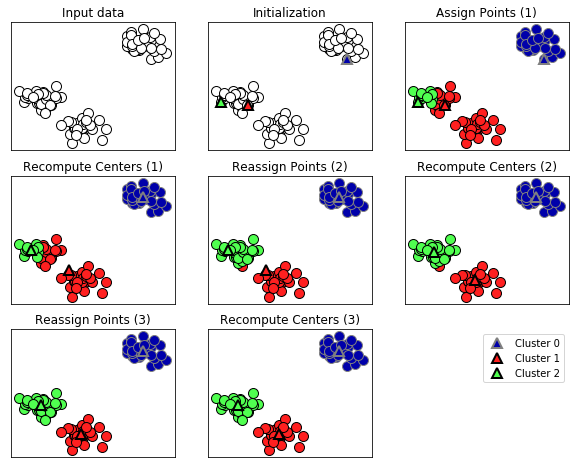

In [2]:
mglearn.plots.plot_kmeans_algorithm()

1. 最初に、ランダムに選択した任意の数(3つ)のデータポイントを、各クラスの重心と割り当てる。  

2. 次に、個々のデータポイントを、最寄りのクラスタ重心のクラスに割り当てる。  

3. そして、ここのクラスタごとに重心を再計算する。

<br>

以降は2と3を繰り返して、クラスタ重心が動かなくなったら終了する。

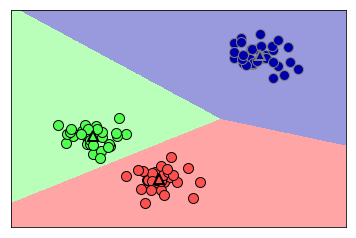

In [3]:
mglearn.plots.plot_kmeans_boundaries()

実装してみる。

In [4]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# 合成2次元データを作る。
X, y = make_blobs(random_state=1)

# クラスタリングモデルを作る
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

<br>

個々のデータポイントに対して、クラスタラベルが割り振られる。  
これは***kmeans.labels_***属性で確認できる。

In [5]:
print("Cluster memberships:\n{}".format(kmeans.labels_))

Cluster memberships:
[1 2 2 2 0 0 0 2 1 1 2 2 0 1 0 0 0 1 2 2 0 2 0 1 2 0 0 1 1 0 1 1 0 1 2 0 2
 2 2 0 0 2 1 2 2 0 1 1 1 1 2 0 0 0 1 0 2 2 1 1 2 0 0 2 2 0 1 0 1 2 2 2 0 1
 1 2 0 0 1 2 1 2 2 0 1 1 1 1 2 1 0 1 1 2 2 0 0 1 0 1]


In [6]:
print(kmeans.predict(X))

[1 2 2 2 0 0 0 2 1 1 2 2 0 1 0 0 0 1 2 2 0 2 0 1 2 0 0 1 1 0 1 1 0 1 2 0 2
 2 2 0 0 2 1 2 2 0 1 1 1 1 2 0 0 0 1 0 2 2 1 1 2 0 0 2 2 0 1 0 1 2 2 2 0 1
 1 2 0 0 1 2 1 2 2 0 1 1 1 1 2 1 0 1 1 2 2 0 0 1 0 1]


クラスタリングには真のラベルは存在しないので、付与されたラベルそのものには意味がない。

<br>

クラスタ重心(センタ)は、***cluster_centers_***属性に格納されている。

△で表示させる。

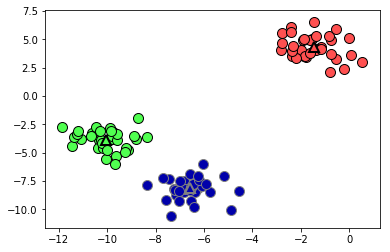

In [7]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers='o')
mglearn.discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2],
    markers='^', markeredgewidth=2)

<br>

クラスタの数は任意に決められる。

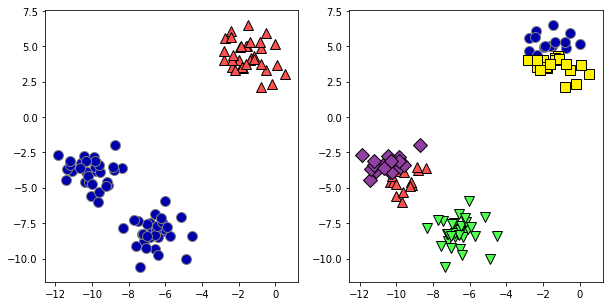

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# using two cluster centers:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
assignments = kmeans.labels_

mglearn.discrete_scatter(X[:, 0], X[:, 1], assignments, ax=axes[0])

# using five cluster centers:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
assignments = kmeans.labels_

mglearn.discrete_scatter(X[:, 0], X[:, 1], assignments, ax=axes[1])

<br>

#### 3.5.1.1 k-meansがうまくいかない場合

k-meansは比較的単純な形しか見つけられない。

Text(0,0.5,'Feature 1')

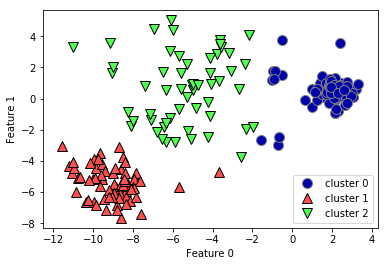

In [9]:
X_varied, y_varied = make_blobs(n_samples=200,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=170)
y_pred = KMeans(n_clusters=3, random_state=0).fit_predict(X_varied)

mglearn.discrete_scatter(X_varied[:, 0], X_varied[:, 1], y_pred)
plt.legend(["cluster 0", "cluster 1", "cluster 2"], loc='best')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

左下(クラスタ1)および右上(クラスタ0)に密集している領域があるが、  
かなり離れた領域までクラスタに含まれてしまっている。

また、次の図のように明らかに3つの領域に分割できるデータに対して、  
k-meansは妥当ではないクラスタ割り当てを行っている。

Text(0,0.5,'Feature 1')

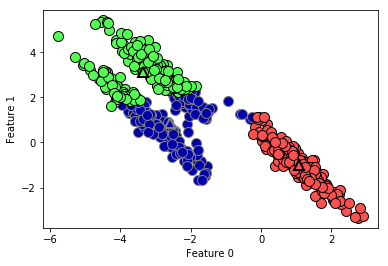

In [10]:
# ランダムにクラスタデータを作成
X, y = make_blobs(random_state=170, n_samples=600)
rng = np.random.RandomState(74)

# 対角線方向に引き延ばす
transformation = rng.normal(size=(2, 2))
X = np.dot(X, transformation)

# データポイントを3つにクラスタリング
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_pred = kmeans.predict(X)

# クラスタ割り当てとクラスタセンタをプロット
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers='o')
mglearn.discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2],
    markers='^', markeredgewidth=2)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

これは、k-meansが最も近いクラスタセンタへの距離しか考慮しないから。

Text(0,0.5,'Feature 1')

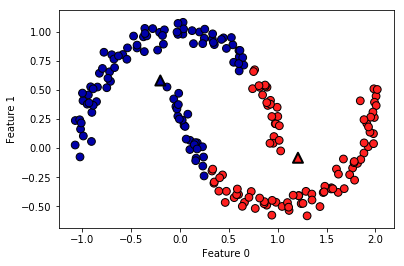

In [11]:
# 合成データセットtwo_monnsデータ作成
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# 2つのクラスタに分類
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_pred = kmeans.predict(X)

# クラスタ割り当てとクラスタセンタをプロット
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=mglearn.cm2, s=60, edgecolor='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='^', c=[mglearn.cm2(0), mglearn.cm2(1)], s=100, linewidth=2,
            edgecolor='k')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

2つの半月型への割り当てを期待したが、k-meansは複雑な形に対応できない。

ただし、多数のクラスタセンタで分類すれば、データを表現することができる。

Cluster memberships:
[9 2 5 4 2 7 9 6 9 6 1 0 2 6 1 9 3 0 3 1 7 6 8 6 8 5 2 7 5 8 9 8 6 5 3 7 0
 9 4 5 0 1 3 5 2 8 9 1 5 6 1 0 7 4 6 3 3 6 3 8 0 4 2 9 6 4 8 2 8 4 0 4 0 5
 6 4 5 9 3 0 7 8 0 7 5 8 9 8 0 7 3 9 7 1 7 2 2 0 4 5 6 7 8 9 4 5 4 1 2 3 1
 8 8 4 9 2 3 7 0 9 9 1 5 8 5 1 9 5 6 7 9 1 4 0 6 2 6 4 7 9 5 5 3 8 1 9 5 6
 3 5 0 2 9 3 0 8 6 0 3 3 5 6 3 2 0 2 3 0 2 6 3 4 4 1 5 6 7 1 1 3 2 4 7 2 7
 3 8 6 4 1 4 3 9 9 5 1 7 5 8 2]


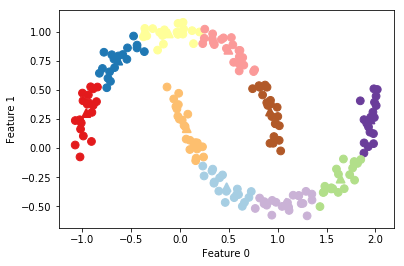

In [12]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(X)
y_pred = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=60, cmap='Paired')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=60,
            marker='^', c=range(kmeans.n_clusters), linewidth=2, cmap='Paired')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
print("Cluster memberships:\n{}".format(y_pred))

半月型という形はとらえられないが、それぞれのクラスタを特徴量として扱えば、線形モデルで分離できる。

<br>

k-meansは非常に広く使われているクラスタリング手法である。  
これは、比較的理解しやすく、また高速に実行できるから。

欠点としては、初期化が乱数で行われるので、乱数シードに依存すること。
* 対策としてk-meansでは、デフォルトで異なる乱数を用いて10回実行し、最良の結果を出力している。

また、クラスタの数をユーザーが指定しなければならない点も欠点として挙げられる。

<br>

そこで、これらの特性を改良したクラスタリングアルゴリズムを見ていく。

<br>

#### 3.5.2 凝集型クラスタリング

凝集型クラスタリング(agglomerative clustering)とは、  
個々のデータポイントを別個のクラスタとして開始し、最も類似したクラスタを併合していく手法である。

<br>

似ていると判定する指標である連結(linkage)度は複数ある。

1. ward
    デフォルト。クラスタ内の分散の増分が最小にする
    
2. average
    クラスタ間のすべてのポイント間の距離の平均値を最小にする
    
3. complete
    2つのクラスタの点間の距離の最大値を最小にする
    
基本的にはデフォルトである**ward**のままでよい

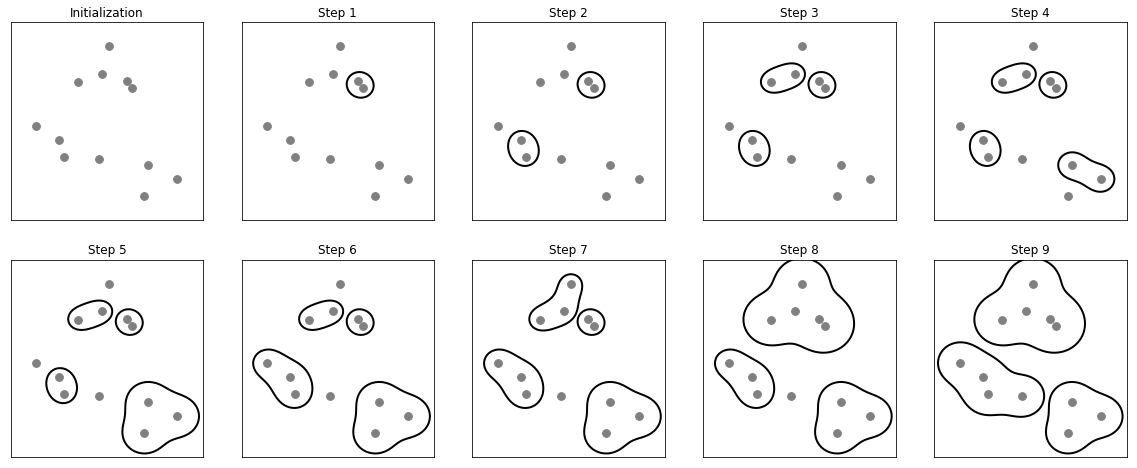

In [13]:
mglearn.plots.plot_agglomerative_algorithm()

この例では、ステップごとに最も近い2つのクラスタが併合され、最終的にユーザーが指定したクラスタ数(3)で終了している。

3クラスタデータに適用してみる。

Text(0,0.5,'Feature 1')

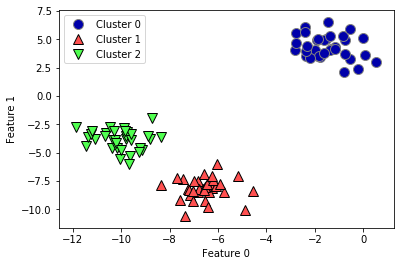

In [14]:
from sklearn.cluster import AgglomerativeClustering
X, y = make_blobs(random_state=1)

agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X)

mglearn.discrete_scatter(X[:, 0], X[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0,0.5,'Feature 1')

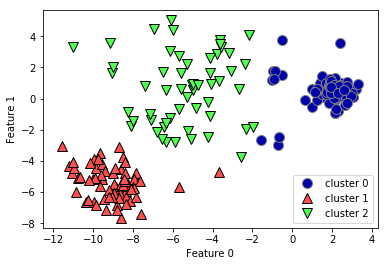

In [15]:
X_varied, y_varied = make_blobs(n_samples=200,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=170)
y_pred = KMeans(n_clusters=3, random_state=0).fit_predict(X_varied)

mglearn.discrete_scatter(X_varied[:, 0], X_varied[:, 1], y_pred)
plt.legend(["cluster 0", "cluster 1", "cluster 2"], loc='best')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0,0.5,'Feature 1')

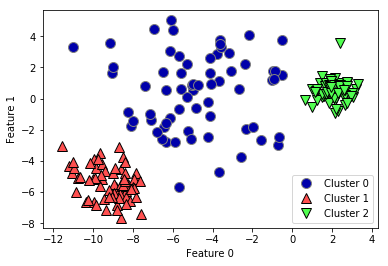

In [16]:
X_varied, y_varied = make_blobs(n_samples=200,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=170)
agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X_varied)

mglearn.discrete_scatter(X_varied[:, 0], X_varied[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

k-meansと比較し、密な集合をとらえることができている。

ただし、two_moonsのような複雑な形状はうまく扱えない。

このような複雑な形状には、**DBSCAN**を用いる。

<br>

#### 3.5.3 DBSCAN


DBSCANは「Density-Based Spatial Clustering of Applications with Noise」の略。  
主な利点は、クラスタ数を指定する必要がないことと、どのクラスタにも属さない点を判別できること。

DBSCANは特徴空間において、多くの点が近接しているような「混んでいる」領域に属する点を見つけ、クラスタに割り当てる。  

<br>

具体的な手順としては以下のようになる。

1. 適当に1つのデータポイントを選ぶ

1. そのデータポイントから距離***eps***以内に***min_samples***以上のデータポイントがある場合に、  
選んだデータポイントを**コアサンプル**とし、新しいクラスタラベルを割り当てる。  
min_samples以上存在しない場合は**ノイズ**とする。

1. 距離eps以内にある近傍点をテストし、それらの点がクラスタに割り当てられてなければ、  
今作ったばかりの新しいクラスタラベルを割り当てる。

1. 近傍点がコアサンプルであれば、さらにその近傍点もテストしていく。  
結果、クラスタからeps以内にコアサンプルが存在しなくなるまで成長を続ける。

1. クラスタの成長が終わったら、まだ調べていない点を選んで同じ手続きを繰り返す。

<br>

最終的には、3種類のデータポイントができる。
* コアサンプル
* コアサンプルから距離eps以内にあるデータポイント(**境界ポイント**と呼ぶ)
* ノイズ

<br>

DBSCANがどのように動作するか、図を用いて確認する。

min_samples: 2 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 2 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 2 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 2 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 3 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 3 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 3 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 3 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 5 eps: 1.000000  cluster: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
min_samples: 5 eps: 1.500000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 2.000000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]


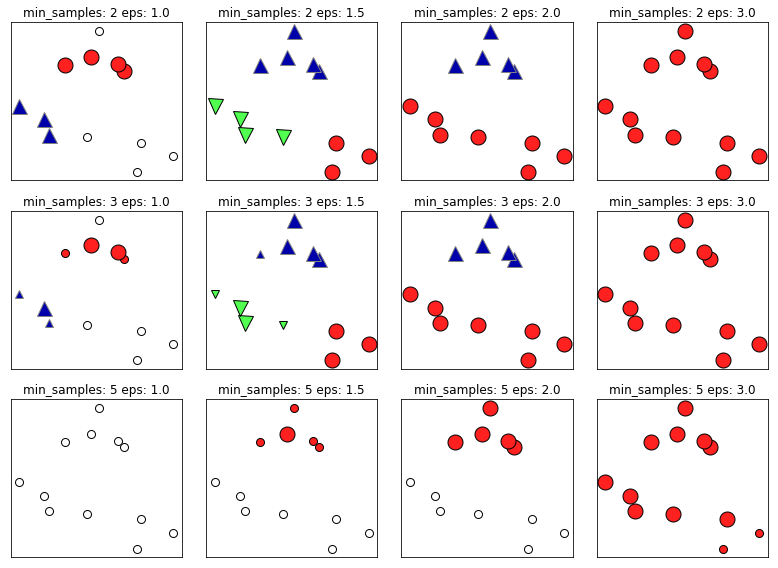

In [18]:
mglearn.plots.plot_dbscan()

上の図は、クラスタに属するポイントには色を付けてあり、ノイズは白で表している。  
また、コアサンプルは大きなマーカ、境界ポイントは小さいマーカである。

epsの値を大きくすると(左から右)、より多くの点が1つのクラスタに含まれるようになる。  
また、min_samplesの値を大きくすると(上から下)、より多くのデータポイントがノイズになる。

このように、DBSCANでは明示的にクラスタの数を設定する必要はないが、  
epsの設定で暗黙的にクラスタ数を制御することになる。

良いepsの値を見つけるために、データは**スケール変換**してからDBSCANを実施するほうが良い。  
これらのスケール変換を行うと、すべての特徴量が同じ範囲になることが保証され、epsの設定が容易となる。

<br>

DBSCANをtwo_monnsデータセットに適応してみる。

Text(0,0.5,'Feature 1')

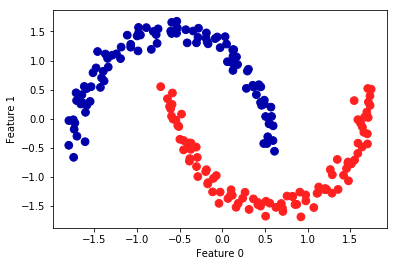

In [19]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# データを平均0、分散1にスケール変換
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_scaled)

# クラスタリング結果をプロット
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

デフォルトのパラメータで望ましいクラスタ数(2)を見つけることができ、またその分類も妥当に見える。

<br>

#### 3.5.4 クラスタリングアルゴリズムの比較と評価

クラスタリングアルゴリズムを利用する際の問題の1つに、アルゴリズムがどの程度うまく機能したか判断するのが難しいことが挙げられる。

ここでは実データセットをもとにそれを確認してみる。

<br>

#### 3.5.4.1 正解データを用いたクラスタリングの評価

クラスタリングアルゴリズムの出力を、正解と比較して評価するために用いられる指標がいくつかある。

最も重要なものは、**調整ランド指数**(adjusted rand index : **ARI**)と、  
**正規化相互情報量**(normalized mutual information : NMI)である。

これらは定量的な指標であり、最良の場合は1、関係ないクラスタリングの場合に0(もしくは負の値)をとる。

ここでは、k-means、凝集型クラスタリング、DBSCAN、ランダム割り当てをARIで比較してみる。

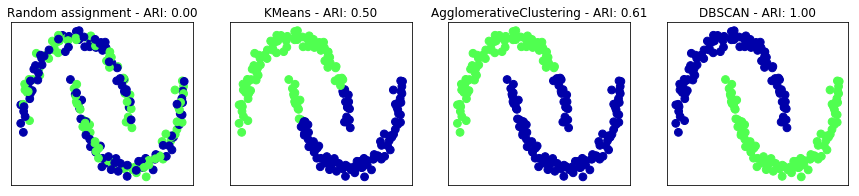

In [20]:
from sklearn.metrics.cluster import adjusted_rand_score
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# データを平均0、分散1にスケール変換する
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# 利用するアルゴリズムのリストを作る
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

# 比較のためにランダムなクラスタ割り当てを作る
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# ランダムな割り当てをプロット
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y, clusters)))

ARIの結果は直感的に理解しやすい。ランダムクラスタ割り当てはスコア0で、DBSCANは1となっている。

クラスタリングを評価する上でよくある間違いは、ARIやNMIではなくaccuracy_scoreを用いてしまうこと。  
accuracy_scoreでは割り当てられたラベル名が正解と一致していることが要求される。

重要なのはクラスタラベルそのものではなく、どのクラスタにどのデータポイントが含まれているか、という点。

In [21]:
from sklearn.metrics import accuracy_score

# この2つのラベルは、同じクラスタリングを表している。
clusters1 = [0, 0, 1, 1, 0]
clusters2 = [1, 1, 0, 0, 1]

# accuracy(精度)は0になる。ラベルが一致していないから。
print("Accuracy: {:.2f}".format(accuracy_score(clusters1, clusters2)))

# ARIスコアは1になる。
print("ARI: {:.2f}".format(adjusted_rand_score(clusters1, clusters2)))

Accuracy: 0.00
ARI: 1.00


<br>

#### 3.5.4.2 正解データを用いないクラスタリングの評価

上ではクラスタリングを評価する方法の1つを示したが、実際にはARIのような指標を用いるのは困難である。  
なぜなら、そもそもクラスタリングアルゴリズムを用いる際に、正解データが無い場合が多いからである。

そもそも、正解データがあるなら、クラス分類器のような教師ありモデルを作ればよいからである。

したがって、ARIやNMIのような指標はアルゴリズムの開発過程でしか利用できず、  
アプリケーションがうまくいっているかどうかの指標にはならない。

<br>

正解データを必要としない**シルエット係数**(silhouette coefficient)もあるが、  
これらの指標はあまりうまく機能しないことが多い。

シルエット係数は、クラスタのコンパクトさを計算する。大きい方が良く、完全な場合で1になる。  
ただし、複雑な形状のクラスタにはうまく機能しない。

two_moonsデータセットに対して、各アルゴリズムをシルエットスコアで評価してみる。

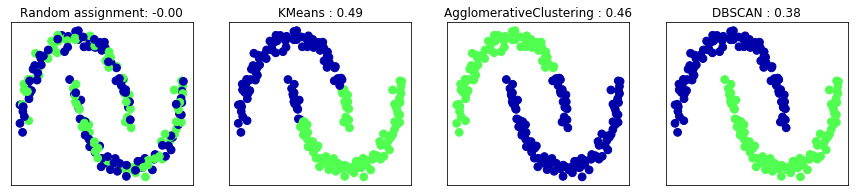

In [22]:
from sklearn.metrics.cluster import silhouette_score

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# データを平均0、分散1にスケール変換する
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# 比較のためにランダムなクラスタ割り当てを作る
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# ランダムな割り当てをプロット
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_scaled, clusters)))

直感的にDBSCANの方が良さそうに見えるが、k-meansの方がシルエットスコアが高い。

結局のところ、クラスタリングアルゴリズムを評価するには、人間がクラスタを目で見て解析してみるしかない。

<br>

#### 3.5.5 クラスタリング手法のまとめ

クラスタリング手法の概要と、それぞれの長所・短所を学んだ。  
また、評価する際には実際には人間が解析する必要性について示した。  

実際にはクラスタリングは、探索的データ解析(EDA)の場面で最も役に立ち、  
アプリケーションの中に組み込んで作動するには不向きな場合が多い。

実際に業務に活用する場合は十分注意して欲しい。

<br>

---

### 3.6 まとめと展望

本章では、さまざまな教師なし学習アルゴリズムを学び、これらがEDAや前処理に活用できることを示した。  
教師なしアルゴリズムの効果を定量的に測ることは難しい場合が多いが、だからといって使用を躊躇うのはもったいない。

ここまでで教師あり学習、教師なし学習で一般的に使われているアルゴリズムを学んできたので、  
次はそれらを活用して実際のアプリケーションを構築する際に重要な、  
**特徴量エンジニアリング**について学んでいく。

<br>

---

## おわり

誤字脱字、不明点あればご連絡ください。